In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')  # Set whitegrid style from Seaborn
#import mplfinance as mpf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.express as px
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

from collections import defaultdict
from scipy import stats

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)

#Keras
import tensorflow as tf

# keras keras

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate,Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import Sequential
#from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Dropout, GRU, Bidirectional,Dense
from keras.layers import GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.layers import Embedding, LSTM,Dense
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers import concatenate
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Time-series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

#KERAS GRID Search
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.activations import swish
#
import math
#
#Seasonality, decompsition
#import statsmodels.api as sm
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
#
from datetime import datetime
from datetime import timedelta
#
import pickle

### FUNCTION DEFINITIONS

In [2]:
#Function to separate the DATA for LSTM
def createXY(dataset, n_lags):

    dataX, dataY = [], []

    for i in range(n_lags, len(dataset)):
            dataX.append(dataset[i - n_lags:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])

    return np.array(dataX),np.array(dataY)

In [3]:
#Defining Various Functions
def mean_error(y_true, y_pred):
   return np.mean(y_true - y_pred) 


def mean_directional_accuracy(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    MDA measures the percentage of times the forecast and the actual values move in the same direction (i.e., both increase or both decrease).
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check if inputs are of the same length and non-empty
    if len(actual) != len(predicted):
        raise ValueError("The lengths of actual and predicted must be the same.")
    if len(actual) < 2:
        raise ValueError("The length of the time series must be at least 2 to compute MDA.")
    
    # Calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # Count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # Calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda
#
def directional_accuracy(actual, predicted):
    """
    Calculates the Directional Accuracy (DA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The DA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check if inputs are of the same length and non-empty
    if len(actual) != len(predicted):
        raise ValueError("The lengths of actual and predicted must be the same.")
    if len(actual) < 2:
        raise ValueError("The length of the time series must be at least 2 to compute DA.")
    
    # Calculate differences between consecutive values
    actual_diff = np.diff(actual)
    predicted_diff = np.diff(predicted)
    
    # Calculate the indicator function for directional accuracy
    indicator = (predicted_diff * actual_diff) > 0
    
    # Count the number of correct directions
    num_correct_directions = np.sum(indicator)
    
    # Calculate the DA value
    da = num_correct_directions / (len(actual) - 1)
    
    return da

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Root Mean Squared Error
    me = mean_error(y_true, y_pred)
    mda = mda(y_true, y_pred)
    da = da(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, me,mda,da, r2


In [4]:
# Define the evaluation function
def evaluation(y_test, y_pred, data_test,title):
    # Plot the actual vs predicted values
    fig = plt.figure(figsize=(8, 3))
    plt.plot(y_test, color='red', label='Actual')
    plt.plot(y_pred, color='blue', label='Predicted')
    #plt.xticks(np.arange(0, len(df_ai_test), 100), df_ai_test.index[np.arange(0, len(df_ai_test), 100)], rotation=45)
    plt.title(f"Predictions vs Actual Data using {title}")
    #plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('EUR')
    plt.legend()
    plt.grid(False)

    # Assuming df_ai_test.index is a datetime index
    plt.xticks(np.arange(0, len(data_test), 100), data_test.index[np.arange(0, len(data_test), 100)].strftime('%Y-%m-%d'), rotation=45)

    # Use DateFormatter to format the x-axis to show only date
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))  # Adjust the interval as needed
    # Calculate metrics
    #mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    me = mean_error(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)
    da  = directional_accuracy(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Round metrics for display
   # mape = np.round(mape, 3)
    mae = np.round(mae, 3)
    mse = np.round(mse, 3)
    rmse = np.round(rmse, 3)
    me = np.round(me, 3)
    mda = np.round(mda, 3)
    da= np.round(da, 3)
    r2 = np.round(r2, 3)

    # Print metrics
    print('MAE: %f  --  MSE: %f  --  RMSE: %f  --  ME: %f  --  MDA: %f  --  DA: %f  --  R2: %f' % 
          (mae, mse, rmse, me, mda, da, r2))

    return mae, mse, rmse, me, mda, da, r2

In [5]:
def plot_model_loss(history, title):
    """
    Plot the training and validation loss for a given history object.

    Parameters:
    - history: The history object returned by the fit method of a Keras model.
    - title: The title of the plot.
    """
    plt.figure(figsize=(8, 3.5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.show()

### The DATAFRAME - READ AND PREPARE THE DATA

In [6]:
merged_df = pd.read_csv('allfeatures_sin.csv')

In [7]:
merged_df.drop(columns = ['Unnamed: 0'],axis=1,inplace = True)

In [8]:
df_ai=merged_df.copy()
df_ai.head()

,datetime_from,price,price1,price2,price3,is_weekend,is_holiday,dayofweek_sin,dayofweek_cos,month_sin,month_cos,hour_sin,hour_cos
0,2023-07-28 00:00:00,107.99,98.83,95.05,107.123,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.000000,1.000000
1,2023-07-28 01:00:00,106.04,95.19,93.70,104.801,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.258819,0.965926
2,2023-07-28 02:00:00,106.10,97.00,87.98,102.977,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.500000,0.866025
3,2023-07-28 03:00:00,105.00,100.36,89.45,109.143,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.707107,0.707107
4,2023-07-28 04:00:00,102.22,109.23,101.46,116.560,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.866025,0.500000


In [9]:
df_ai['datetime_from'] = pd.to_datetime(df_ai['datetime_from'])
df_ai = df_ai.set_index('datetime_from')
df_ai = df_ai.asfreq('1H')
df_ai = df_ai.sort_index()

In [10]:
df_ai.index.freq

<Hour>

In [11]:
(df_ai.index == pd.date_range(start=df_ai.index.min(),
                              end=df_ai.index.max(),
                              freq=df_ai.index.freq)).all()

True

### Separating the DATA for TRAINING

In [12]:
## Block to Separate Data into TRAIN - TEST - VALIDATION

start_date = df_ai.index.min()
end_date = df_ai.index.max()
total_days = (end_date - start_date).days + 1

end_train = end_train = '2024-05-21 23:00:00'
start_validation = '2024-05-22 00:00:00'
end_validation = '2024-06-25 23:00:00'
start_test = '2024-06-26 00:00:00'
#
df_ai_train = df_ai.loc[:end_train, :]
df_ai_val = df_ai.loc[start_validation:end_validation, :]
df_ai_test = df_ai.loc[start_test:, :]

print('total_days:', total_days)
print(f"Train dates      : {df_ai_train.index.min()} --- {df_ai_train.index.max()}  (h={len(df_ai_train)}) --- (d = {len(df_ai_train)//24})")
print(f"Validation dates : {df_ai_val.index.min()} --- {df_ai_val.index.max()}  (h={len(df_ai_val)})--- (d = {len(df_ai_val)//24})")
print(f"Test dates       : {df_ai_test.index.min()} --- {df_ai_test.index.max()}  (h={len(df_ai_test)})--- (d = {len(df_ai_test)//24})")


total_days: 344
Train dates      : 2023-07-28 00:00:00 --- 2024-05-21 23:00:00  (h=7176) --- (d = 299)
Validation dates : 2024-05-22 00:00:00 --- 2024-06-25 23:00:00  (h=840)--- (d = 35)
Test dates       : 2024-06-26 00:00:00 --- 2024-07-05 23:00:00  (h=240)--- (d = 10)


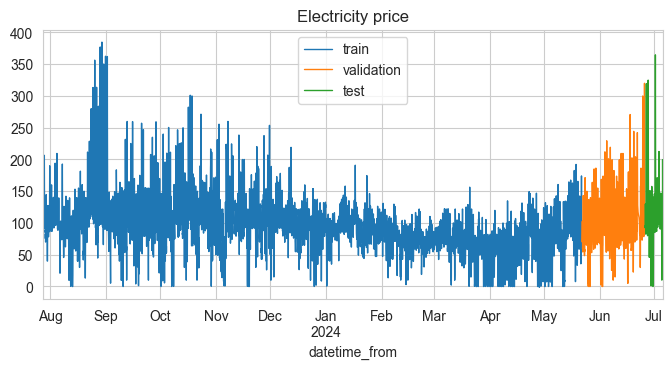

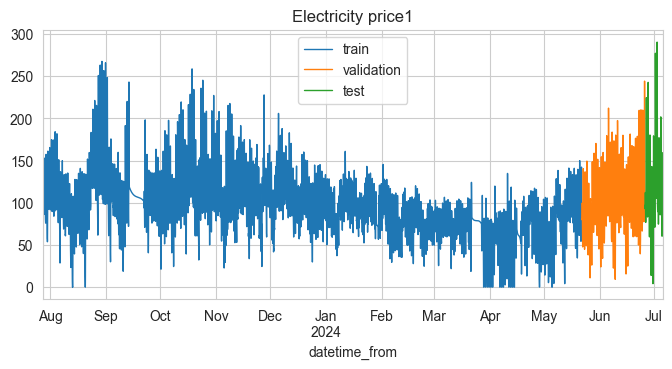

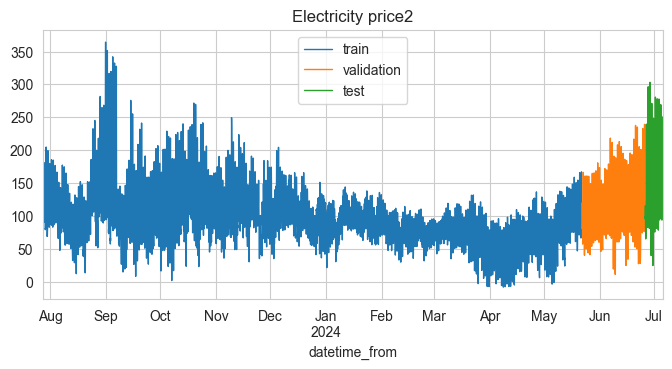

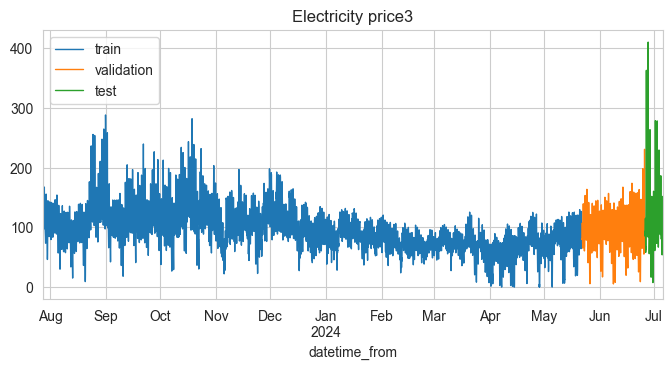

In [13]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 3.5))

# Plot the train, validation, and test data
df_ai_train.price.plot(ax=ax, label='train', linewidth=1)
df_ai_val.price.plot(ax=ax, label='validation', linewidth=1)
df_ai_test.price.plot(ax=ax, label='test', linewidth=1)

# Set the title and legend
ax.set_title('Electricity price')
ax.legend()

# Show the plot
plt.show()

# Plot for price1
fig, ax = plt.subplots(figsize=(8, 3.5))
df_ai_train.price1.plot(ax=ax, label='train', linewidth=1)
df_ai_val.price1.plot(ax=ax, label='validation', linewidth=1)
df_ai_test.price1.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity price1')
ax.legend()
plt.show()

# Plot for price2
fig, ax = plt.subplots(figsize=(8, 3.5))
df_ai_train.price2.plot(ax=ax, label='train', linewidth=1)
df_ai_val.price2.plot(ax=ax, label='validation', linewidth=1)
df_ai_test.price2.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity price2')
ax.legend()
plt.show()

# Plot for price3
fig, ax = plt.subplots(figsize=(8, 3.5))
df_ai_train.price3.plot(ax=ax, label='train', linewidth=1)
df_ai_val.price3.plot(ax=ax, label='validation', linewidth=1)
df_ai_test.price3.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity price3')
ax.legend()
plt.show()

In [14]:
print("Script started at:", datetime.now())

Script started at: 2024-07-19 21:35:35.797851


### SCALE THE DATA

In [15]:
#Introduced MINMAX Scaler for (01)
scaler1 = MinMaxScaler(feature_range=(0,1))
data_train_scaled1 = scaler1.fit_transform(df_ai_train.values)
data_val_scaled1 = scaler1.transform(df_ai_val.values)
data_test_scaled1 = scaler1.transform(df_ai_test.values)

### DEFINE PARAMETERS

The hyperparameter search is complete.

Optimal number of units in the 1st GRU layer: 64

Optimal number of units in the 2nd GRU layer: 128

Optimal Activation: elu

Optimal Activation: relu

Optimal learning rate: 0.001

In [16]:
### Define Parameters
# Define Parameters
params = {
    'neurons1': 64,
    'neurons2': 128,
    'batch_size': 32,
    'epochs': 40,
    'lags': 24,
    'loss': 'mean_absolute_error',
    'learning_rate': 0.001,
    'activation1': 'elu',
    'activation2': 'relu',
    'reduce_lr': ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=8, verbose=2, mode='auto', min_delta=0.01, cooldown=0, min_lr=0),
}
optimizer =  Adam(learning_rate=params['learning_rate'])


### CREATE TRAIN VALIDATION TEST LAGGED FEATURES

In [17]:
trainX1, trainY1 = createXY(data_train_scaled1, params['lags'])
valX1,   valY1   = createXY(data_val_scaled1,  params['lags'])
testX1,  testY1  = createXY(data_test_scaled1,  params['lags'])

In [18]:
trainX1.shape,trainY1.shape,valX1.shape,valY1.shape,testX1.shape,testY1.shape

((7152, 24, 12), (7152,), (816, 24, 12), (816,), (216, 24, 12), (216,))

### DEFINE THE MODEL

In [19]:
model1 = Sequential()
model1.add(GRU(units= params['neurons1'], activation=params['activation1'],input_shape=(trainX1.shape[1], trainX1.shape[2]),return_sequences=True))
model1.add(GRU( units = params['neurons2'], activation=params['activation2'], return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))
model1.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
# Train the model
history1 = model1.fit(trainX1, trainY1, epochs=params['epochs'], validation_data=(valX1, valY1), batch_size=params['batch_size'], callbacks=[params['reduce_lr']])
    

Epoch 1/40


c:\Users\kathe\miniconda3\envs\DEH\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0744 - mae: 0.0744 - val_loss: 0.0442 - val_mae: 0.0442 - learning_rate: 0.0010
Epoch 2/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0342 - val_mae: 0.0342 - learning_rate: 0.0010
Epoch 3/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0327 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 4/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0310 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 5/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0327 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 6/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0313 - val_mae: 0.0313 - learning_rate: 0.0010
Epoch 7/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0287 - val_mae: 0.0287 - learning_rate: 0.0010
Epoch 8/40

In [20]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,171 (1.06 MB)

 Trainable params: 92,723 (362.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 185,448 (724.41 KB)

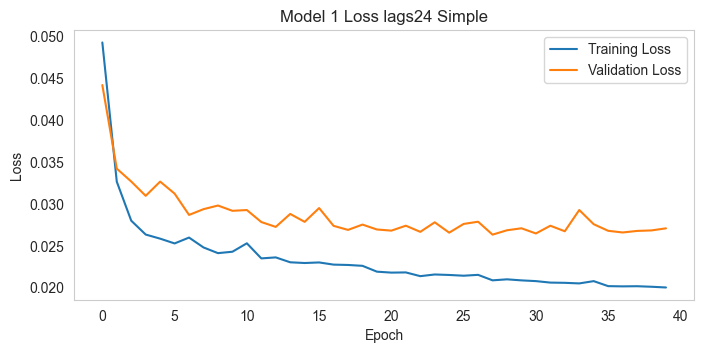

In [21]:
# Format the plot title string using an f-string
model_name1 = 'Model 1'
lags = params['lags']
plot_title1 = f'{model_name1} Loss lags{lags} Simple'
plot_model_loss(history1,plot_title1)

In [22]:
prediction1=model1.predict(testX1)
prediction_reverselyscaled1 = scaler1.inverse_transform(np.repeat(prediction1, data_test_scaled1.shape[1], axis=-1))[:, 0]
testY1 = testY1.reshape(-1, 1)
testY_extended1 = np.hstack([testY1, np.zeros((testY1.shape[0], data_test_scaled1.shape[1] - 1))])
y_test1 = scaler1.inverse_transform(testY_extended1)[:, 0]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [23]:
y_test1.shape,prediction_reverselyscaled1.shape,df_ai_test.shape

((216,), (216,), (240, 12))

MAE: 9.317000  --  MSE: 218.123000  --  RMSE: 14.769000  --  ME: -0.838000  --  MDA: 0.781000  --  DA: 0.781000  --  R2: 0.919000


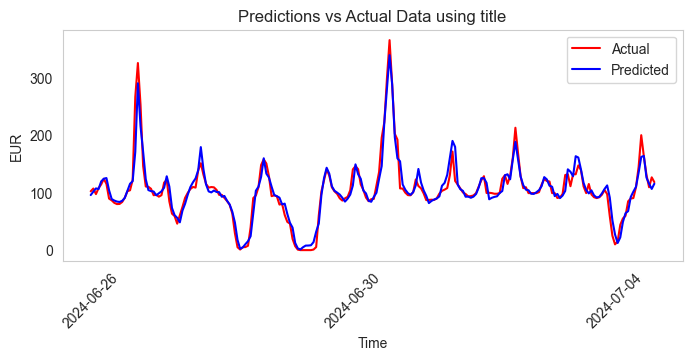

In [24]:
mae, mse, rmse, me, mda, da, r2 = evaluation(y_test1, prediction_reverselyscaled1, df_ai_test,'title')

### Export the GRU MODEL

In [27]:
#with KERAS SAving
model1.save('GRU_MODEL_KERAS.keras')

In [28]:
#Save the Scaler MIN_MAX
pickle.dump(scaler1, open('SCALERGRU.pickle', 'wb'))